In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

In [40]:

def read_csv(filename):
    data = pd.read_csv(filename)
    repositories = data.iloc[:, 0].tolist()
    metrics = data.iloc[:, 1:].values
    return repositories, metrics

In [41]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

In [43]:
def create_random_individual(num_features, threshold=0.5):
    return np.random.uniform(0, 1, num_features) > threshold


In [ ]:
def fitness_function(individual, data):
    selected_features = np.where(individual == True)[0]
    if len(selected_features) == 0:
        return 1_000_000  # Penalty if selected 0 features
    selected_data = data[:, selected_features]
    return utils.calculate_sammon_error(data, selected_data)


In [45]:
def initialize_population(population_size, num_features):
    # Init population with high size
    return [create_random_individual(num_features, threshold=0.7) for _ in range(population_size)]


In [46]:

def mutate(population, target_idx, F):
    population_size = len(population)
    indices = list(range(population_size))
    indices.remove(target_idx)
    r1, r2, r3 = np.random.choice(indices, 3, replace=False)

    mutant = population[r1].astype(float) + F * (population[r2].astype(float) - population[r3].astype(float))
    mutant = np.clip(mutant, 0, 1)

    
    mutant = mutant > 0.5  
    return mutant

In [47]:
def crossover(target, mutant, CR):
    trial = np.copy(target)
    for i in range(len(target)):
        if np.random.uniform(0, 1) < CR:
            trial[i] = mutant[i]
    return trial


In [ ]:
def differential_evolution(data, population_size, generations, F=0.5, CR=0.9, stop_tolerance=1e-16, patience=50):
    num_features = data.shape[1]
    population = initialize_population(population_size, num_features)
    fitness_scores = np.array([fitness_function(ind, data) for ind in population])
    
    best_idx = np.argmin(fitness_scores)
    best_individual = population[best_idx]
    best_fitness = fitness_scores[best_idx]

    
    last_improvement = 0
    

    # To detect changing in population 
    fitness_progress = []
    num_features_progress = []

    for gen in range(generations):
        for i in range(population_size):
            mutant = mutate(population, i, F)
            trial = crossover(population[i], mutant, CR)
            trial_fitness = fitness_function(trial, data)

            if trial_fitness < fitness_scores[i]:
                population[i] = trial
                fitness_scores[i] = trial_fitness
                if trial_fitness < best_fitness:
                    best_fitness = trial_fitness
                    best_individual = trial
                    last_improvement = gen

        fitness_progress.append(best_fitness)
        num_features_progress.append(np.sum(best_individual))

        if gen - last_improvement > patience:
            print(f"Nothing changing by: {patience} epoch.")
            break

        if gen % 100 == 0 or gen == generations - 1:
            print(f"Generation {gen}: Best fitness = {best_fitness}")

    return best_individual, best_fitness, fitness_progress, num_features_progress


In [49]:
def save_selected_metrics(repositories, data, selected_features, output_file):
    selected_data = data[:, selected_features]
    selected_df = pd.DataFrame(selected_data, columns=[f"Feature_{i}" for i in selected_features])
    selected_df.insert(0, 'Repository', repositories)
    selected_df.to_csv(output_file, index=False)
    print(f"Selected metrics saved to {output_file}")


Generation 0: Best fitness = 0.009850946176351
Generation 9: Best fitness = 0.000909447256663467
Best fitness: 0.000909447256663467
Selected features: [ 2  8 11 12 16 17 20 26 32 33 35 40 41]
Selected metrics saved to selected_metrics.csv


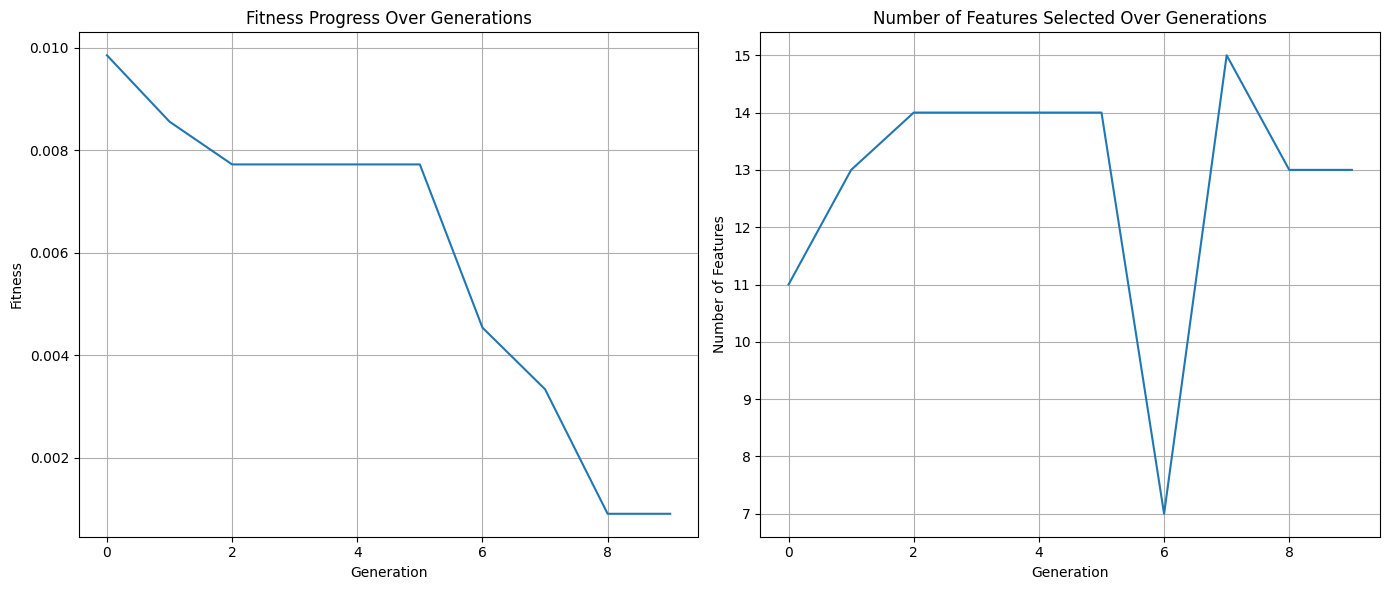

In [50]:
INPUT_FILE = "data_all.csv"
OUTPUT_FILE = "selected_metrics.csv"

GENERATIONS = 10
F = 0.5
CR = 0.9

repositories, metrics = read_csv(INPUT_FILE)
POPULATION_SIZE = len(repositories)

best_individual, best_fitness, fitness_progress, num_features_progress = differential_evolution(
    metrics, POPULATION_SIZE, GENERATIONS, F, CR)

selected_features = np.where(best_individual == True)[0]
print(f"Best fitness: {best_fitness}")
print(f"Selected features: {selected_features}")

# Save results
save_selected_metrics(repositories, metrics, selected_features, OUTPUT_FILE)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(fitness_progress, label='Fitness Progress')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Progress Over Generations')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(num_features_progress, label='Number of Features Selected')
plt.xlabel('Generation')
plt.ylabel('Number of Features')
plt.title('Number of Features Selected Over Generations')
plt.grid(True)

plt.tight_layout()

plt.show()
